# Templating ZTF alerts

## Reading ZTF alerts

Let's first read bunch of ZTF alerts (from January 13 2020)

In [1]:
from fink_client.avroUtils import AlertReader

# Generic reader for Avro files
# You can also specify a single file
r = AlertReader('../sampledata')

# Materialize data as a Pandas DataFrame
alerts = r.to_pandas()

Let's see what in our alerts

In [2]:
alerts.head()

,schemavsn,publisher,objectId,candid,candidate,prv_candidates,cutoutScience,cutoutTemplate,cutoutDifference
0,3.3,ZTF (www.ztf.caltech.edu),ZTF20aaeyyno,1107083294115015013,"{'jd': 2458861.5832986, 'fid': 2, 'pid': 11070...","[{'jd': 2458835.5740856, 'fid': 2, 'pid': 1081...",{'fileName': 'candid1107083294115015013_pid110...,{'fileName': 'candid1107083294115015013_ref.fi...,{'fileName': 'candid1107083294115015013_pid110...
1,3.3,ZTF (www.ztf.caltech.edu),ZTF18abasuac,1107088094015015006,"{'jd': 2458861.5880903, 'fid': 1, 'pid': 11070...","[{'jd': 2458833.6249306, 'fid': 1, 'pid': 1079...",{'fileName': 'candid1107088094015015006_pid110...,{'fileName': 'candid1107088094015015006_ref.fi...,{'fileName': 'candid1107088094015015006_pid110...
2,3.3,ZTF (www.ztf.caltech.edu),ZTF18abscgeq,1107085322515015001,"{'jd': 2458861.5853241, 'fid': 1, 'pid': 11070...","[{'jd': 2458837.5841204, 'fid': 2, 'pid': 1083...",{'fileName': 'candid1107085322515015001_pid110...,{'fileName': 'candid1107085322515015001_ref.fi...,{'fileName': 'candid1107085322515015001_pid110...
3,3.3,ZTF (www.ztf.caltech.edu),ZTF18abuuoea,1107083292715010005,"{'jd': 2458861.5832986, 'fid': 2, 'pid': 11070...","[{'jd': 2458835.5740856, 'fid': 2, 'pid': 1081...",{'fileName': 'candid1107083292715010005_pid110...,{'fileName': 'candid1107083292715010005_ref.fi...,{'fileName': 'candid1107083292715010005_pid110...
4,3.3,ZTF (www.ztf.caltech.edu),ZTF18acfojty,1107082845215010048,"{'jd': 2458861.5828472, 'fid': 2, 'pid': 11070...","[{'jd': 2458833.5703356, 'fid': 2, 'pid': 1079...",{'fileName': 'candid1107082845215010048_pid110...,{'fileName': 'candid1107082845215010048_ref.fi...,{'fileName': 'candid1107082845215010048_pid110...


The first field of interest for us is `candidate` that contains the data for the measurement

In [3]:
# Each row is a dictionary
alerts['candidate'].head()

0    {'jd': 2458861.5832986, 'fid': 2, 'pid': 11070...
1    {'jd': 2458861.5880903, 'fid': 1, 'pid': 11070...
2    {'jd': 2458861.5853241, 'fid': 1, 'pid': 11070...
3    {'jd': 2458861.5832986, 'fid': 2, 'pid': 11070...
4    {'jd': 2458861.5828472, 'fid': 2, 'pid': 11070...
Name: candidate, dtype: object

The other field is `prv_candidates` that contains the history of the alerts over a period of 30 days

In [4]:
# Each row is a list of dictionary
alerts['prv_candidates'].head()

0    [{'jd': 2458835.5740856, 'fid': 2, 'pid': 1081...
1    [{'jd': 2458833.6249306, 'fid': 1, 'pid': 1079...
2    [{'jd': 2458837.5841204, 'fid': 2, 'pid': 1083...
3    [{'jd': 2458835.5740856, 'fid': 2, 'pid': 1081...
4    [{'jd': 2458833.5703356, 'fid': 2, 'pid': 1079...
Name: prv_candidates, dtype: object

Let's focus on one single alert for this exercise:

In [5]:
# Let's take the third alert
alert = r.to_list(10)[2]

In [6]:
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
from fink_client.visualisation import extract_field

def plot_lightcurve(alert_dic: dict) -> None:
    """ Plot the full lightcurve contained in a ZTF alert
    
    Parameters
    ----------
    alert_dic: dict
        Dictionnary containing the alert data
    """
    # Font for plots
    font = {
        'weight': 'bold',
        'size': 22
    }

    matplotlib.rc('font', **font)

    # Bands
    filter_color = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c'}
    # [
    #     '#1f77b4',  # muted blue
    #     '#ff7f0e',  # safety orange
    #     '#2ca02c',  # cooked asparagus green
    #     '#d62728',  # brick red
    #     '#9467bd',  # muted purple
    #     '#8c564b',  # chestnut brown
    #     '#e377c2',  # raspberry yogurt pink
    #     '#7f7f7f',  # middle gray
    #     '#bcbd22',  # curry yellow-green
    #     '#17becf'   # blue-teal
    # ]
    filter_name = {1: 'g band', 2: 'r band', 3: 'i band'}
    
    # extract current and historical data as one vector
    mag = extract_field(alert_dic, 'magpsf')
    error = extract_field(alert_dic, 'sigmapsf')
    upper = extract_field(alert_dic, "diffmaglim")
    
    # filter bands
    fid = extract_field(alert_dic, "fid")
    
    # Rescale dates to end at 0
    jd = extract_field(alert_dic, "jd")
    dates = np.array([i - jd[0] for i in jd])

    # Title of the plot (alert ID)
    title = alert["objectId"]

    # loop over filters
    fig = plt.figure(figsize=(12,4))
    
    # Loop over each filter
    for filt in filter_color.keys():
        mask = np.where(fid == filt)[0]
        
        # Skip if no data
        if len(mask) == 0:
            continue

        # y data
        maskNotNone = mag[mask] != None
        plt.errorbar(
            dates[mask][maskNotNone], mag[mask][maskNotNone], yerr=error[mask][maskNotNone], 
            color=filter_color[filt], marker='o', ls='', label=filter_name[filt], mew=4)
        # Upper limits
        plt.plot(
            dates[mask][~maskNotNone], upper[mask][~maskNotNone], 
            color=filter_color[filt], marker='v', ls='', mew=4, alpha=0.5)
        plt.title(title)
    plt.legend()
    plt.gca().invert_yaxis()
    plt.xlabel('Days to candidate')
    plt.ylabel('Difference magnitude')
    plt.show()


Notice that we focus on `magpsf` and `sigmapsf` - these are the magnitude and error that you want to replace.

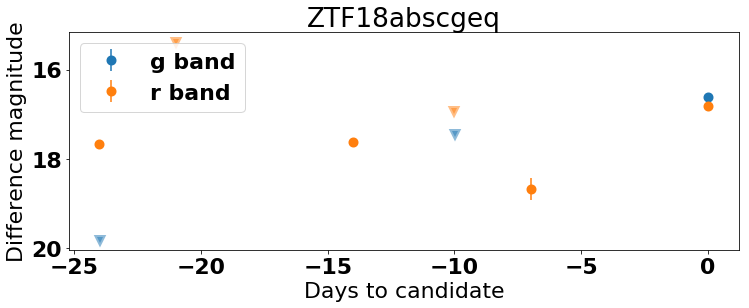

In [7]:
plot_lightcurve(alert)

## Replacing alert data, and saving

Let's replace our alert data, and saving the new alert on disk. We need to replace at least the current measurement, and the previous measurements.

In [8]:
n_historical_measurements = len(alert['prv_candidates'])
print('{} historical measurements'.format(n_historical_measurements))

# Generate fake data over new historical days
jd_min = np.min([alert['prv_candidates'][i]['jd'] for i in range(n_historical_measurements)])
jd_max = alert['candidate']['jd']
print('Historical measurements between {} and {}'.format(jd_min, jd_max))

8 historical measurements
Historical measurements between 2458837.5841204 and 2458861.5853241


Let's put new measurements - beware change in-place! We also do it for different filter bands

In [9]:
[
    alert['prv_candidates'][i].update({'magpsf': 20}) 
    if alert['prv_candidates'][i]['fid'] == 1
    else alert['prv_candidates'][i].update({'magpsf': 19}) 
    for i in range(n_historical_measurements)
]

[
    alert['prv_candidates'][i].update({'sigmapsf': 3}) 
    for i in range(n_historical_measurements) 
]

[
    alert['prv_candidates'][i].update({'diffmaglim': None}) 
    for i in range(n_historical_measurements) 
]

alert['candidate'].update({'magpsf': 15})  
alert['candidate'].update({'sigmapsf': 2})  

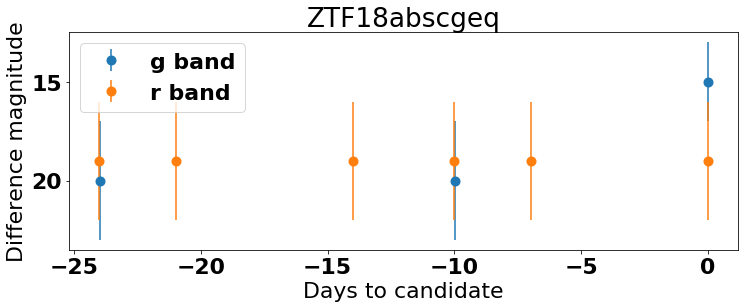

In [10]:
plot_lightcurve(alert)

Of course, one could take into account other alert parameters - but I guess you have the idea! Finally save your new alert:

In [11]:
from fink_client.avroUtils import write_alert
import fastavro

def readschemafromavrofile(fn: str) -> dict:
    """ Reach schema from a binary avro file.

    Parameters
    ----------
    fn: str
        Input Avro file with schema.

    Returns
    ----------
    schema: dict
        Dictionary (JSON) describing the schema.

    """
    with open(fn, mode='rb') as file_data:
        data = fastavro.reader(file_data)
        schema = data.schema
    return schema

schema = readschemafromavrofile(r.filenames[0])

# In this routine, the output filename is not an option
# Do not hesitate to change this routine if you want another output filename.
write_alert(alert, schema, path='.', overwrite=True)

/Users/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The 'schema' attribute is deprecated. Please use 'writer_schema'


Et voilà!

In [12]:
!ls

ZTF18abscgeq.avro           templating_ztf_alerts.ipynb


In [15]:
r2 = AlertReader('ZTF18abscgeq.avro')
r2.to_pandas()

,schemavsn,publisher,objectId,candid,candidate,prv_candidates,cutoutScience,cutoutTemplate,cutoutDifference
0,3.3,ZTF (www.ztf.caltech.edu),ZTF18abscgeq,1107085322515015001,"{'jd': 2458861.5853241, 'fid': 1, 'pid': 11070...","[{'jd': 2458837.5841204, 'fid': 2, 'pid': 1083...",{'fileName': 'candid1107085322515015001_pid110...,{'fileName': 'candid1107085322515015001_ref.fi...,{'fileName': 'candid1107085322515015001_pid110...
